In [1]:
from scipy import stats

In [2]:
from numerov import *

In [3]:
#%matplotlib widget

In [4]:
# Total Length = (7*400)*2 + 4*410 + 3*420

In [5]:
reducedPlanckConstant : float = 1.0

In [6]:
# Liquid sensor based on high-Q slot photonic crystal cavity in silicon-on-insulator configuration
# Charles Caër, Samuel F. Serna-Otálvaro, Weiwei Zhang, Xavier Le Roux, and Eric Cassan
# http://dx.doi.org/10.1364/OL.39.005792

In [7]:
A0InAngstroms : float = 40.0

In [8]:
A1InAngstroms : float = 41.0

In [9]:
A2InAngstroms : float = 42.0

In [10]:
lengthInAngstroms : float = (7 * A0InAngstroms * 2)  + 4 * A1InAngstroms  + A2InAngstroms * 3 

In [11]:
a0PotentialRatio : float = A0InAngstroms / A2InAngstroms

In [12]:
a1PotentialRatio : float = A1InAngstroms / A2InAngstroms

In [13]:
a2PotentialRatio : float = A2InAngstroms / A2InAngstroms

In [14]:
a0LengthRatio : float = A0InAngstroms / lengthInAngstroms

In [15]:
a1LengthRatio : float = A1InAngstroms / lengthInAngstroms

In [16]:
a2LengthRatio : float = A2InAngstroms / lengthInAngstroms

In [17]:
speedOfLightInAnstromsPerSecond : float = 299792458 * 1e-10

In [18]:
def frequencyFromLatticeConstant(
            latticeConstant : float, 
            speedOfLightInAngstromsPerSecond : float = speedOfLightInAnstromsPerSecond
        ) -> float:
    return (2.0 * np.pi * speedOfLightInAngstromsPerSecond) / latticeConstant

In [19]:
unitPotential = (1 / frequencyFromLatticeConstant(A0InAngstroms)) * reducedPlanckConstant

In [20]:
potentialStepHeightRatios : list[float] = [
        a2PotentialRatio, 
        a1PotentialRatio, 
        a0PotentialRatio, 
        a1PotentialRatio, 
        a2PotentialRatio, 
        a1PotentialRatio, 
        a0PotentialRatio, 
        a1PotentialRatio, 
        a2PotentialRatio
    ]

In [21]:
scalar : float = 1.0

In [22]:
lengthRatios : list[float] = [
        a2LengthRatio, 
        a1LengthRatio, 
        7.0 * a0LengthRatio, 
        a1LengthRatio, 
        a2LengthRatio, 
        a1LengthRatio, 
        7.0 * a0LengthRatio, 
        a1LengthRatio, 
        a2LengthRatio
    ]

In [23]:
unitLength = 1

In [24]:
potentialFunction = partial(
        lambda unitLength, unitPotentialHeight, lengthRatios_, potentialStepHeightRatios_, normalizedPositions_ : \
                constantPotentialsWithWidths(
                        normalizedPositions_ + (1.0 / 2.0), \
                        unitLength, \
                        unitPotentialHeight, \
                        lengthRatios, \
                        potentialStepHeightRatios
                    ), 
        unitLength, 
        unitPotential, 
        lengthRatios, 
        potentialStepHeightRatios
    )

In [25]:
results = computeWaveFunction(
        potentialFunction, 
        scalingFactor = scalar, 
        length = unitLength
    )

In [26]:
potential : np.array = results["potential"]

In [27]:
waveFunctions : np.ndarray = results["waveFunctions"]

In [28]:
energies : np.array = results["energies"]

In [29]:
normalizedPositions : np.array = results["normalizedPositions"]

In [30]:
probabilityDistributions : np.ndarray = waveFunctions ** 2

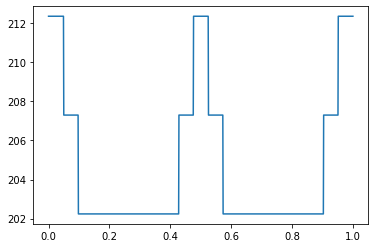

In [31]:
plt.plot(normalizedPositions, potential)

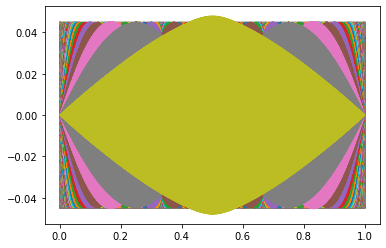

In [32]:
#plt.plot(normalizedPositions, potential / scalar / 10000)
for waveFunction in waveFunctions:
     plt.plot(normalizedPositions[1:], waveFunction)

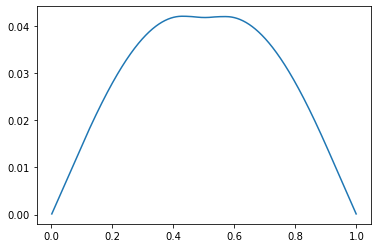

In [33]:
#plt.plot(normalizedPositions, potential / scalar / 10)
plt.plot(normalizedPositions[1:], waveFunctions[0])

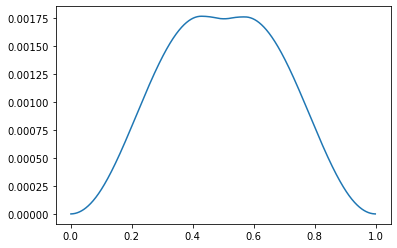

In [34]:
#plt.plot(normalizedPositions, potential / scalar / 100)
plt.plot(normalizedPositions[1:], probabilityDistributions[0])

In [35]:
maxValues : np.array = np.array(list(map(np.max, probabilityDistributions)))
expectationValues : np.array = np.array(list(map(lambda distribution : np.sum(distribution * normalizedPositions[1:]), probabilityDistributions)))

In [36]:
mostProbablePositions : np.array = np.array(list(map(
        lambda probabilityDistribution, maxValue : np.sum(np.where(~(probabilityDistribution == maxValue), 0, normalizedPositions[1:])), 
        probabilityDistributions, 
        maxValues
    )))

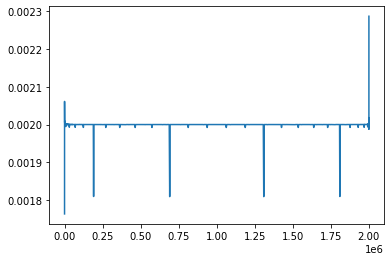

In [37]:
plt.plot(energies, maxValues)

In [38]:
# Eerily similar too the transmission plot in paper?

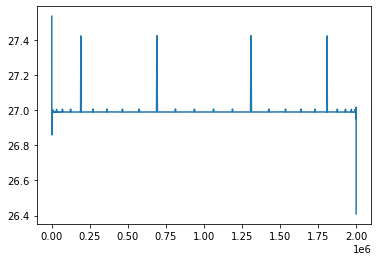

In [39]:
plt.plot(energies, -10 * np.log10(maxValues))

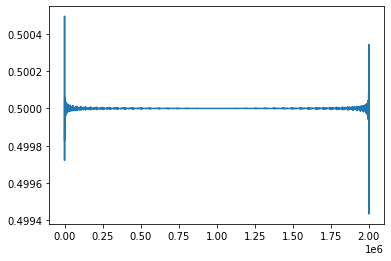

In [40]:
plt.plot(energies, expectationValues)

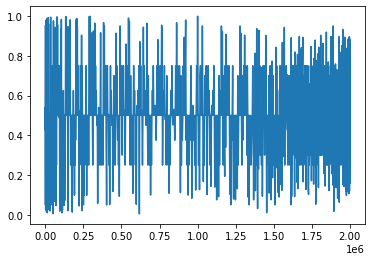

In [41]:
plt.plot(energies, mostProbablePositions)

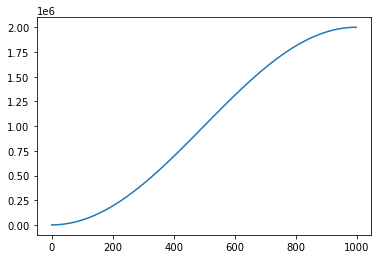

In [42]:
plt.plot(energies)

In [43]:
def binExpectationValuesToRegion(
            expectationValues : np.array, 
            lengthRatios : list, 
            unitLength : float
        ) -> np.array: 
    regionLengths : np.array = np.array([0] + lengthRatios) * unitLength
    expectationRegionBins : np.array = np.zeros(len(energies))
    for ii in range(1, len(regionLengths)): 
            expectationRegionBins = np.where(
                ~((expectationValues < regionLengths[ii]) \
                      & (expectationValues > regionLengths[ii - 1])), 
                expectationRegionBins, 
                ii
            )
    return expectationRegionBins

In [44]:
expectationRegionBins = binExpectationValuesToRegion(expectationValues, lengthRatios, unitLength)

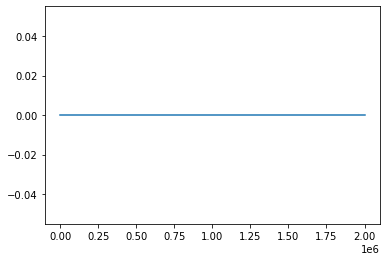

In [45]:
plt.plot(energies, expectationRegionBins)

In [46]:
maxRegionBins = binExpectationValuesToRegion(mostProbablePositions, lengthRatios, unitLength)

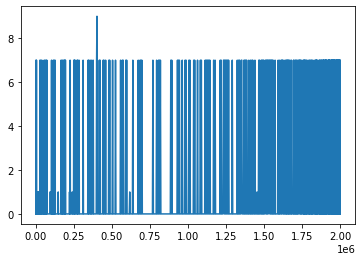

In [47]:
plt.plot(energies, maxRegionBins)

In [48]:
regionPlots : np.ndarray = np.zeros((len(lengthRatios), len(energies)))
for ii, maxRegion in enumerate(maxRegionBins): 
    regionPlots[int(maxRegion) - 1][ii] = mostProbablePositions[ii]

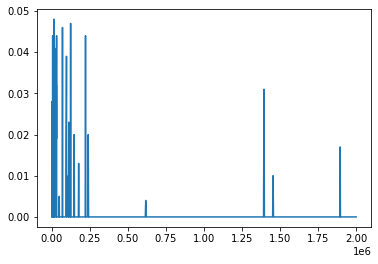

In [49]:
plt.plot(energies, regionPlots[0])

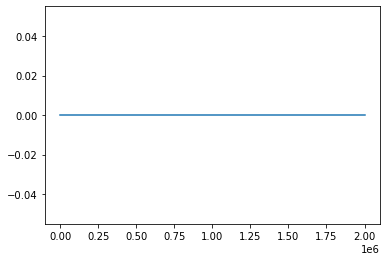

In [50]:
plt.plot(energies, regionPlots[1])

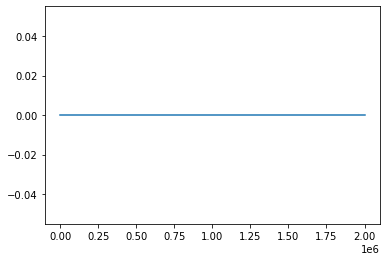

In [51]:
plt.plot(energies, regionPlots[2])

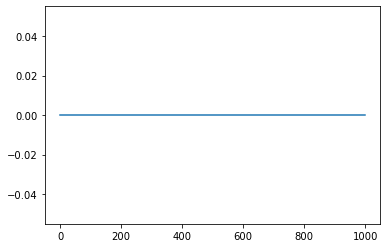

In [52]:
plt.plot(np.sort(regionPlots[2]))

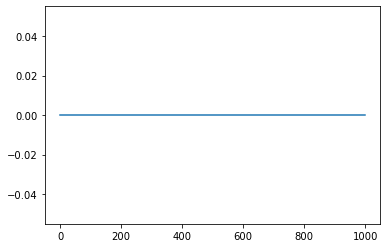

In [53]:
plt.plot(np.sort(regionPlots[2]))

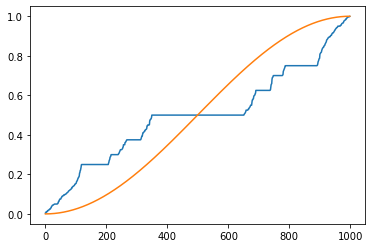

In [54]:
plt.plot(np.sort(mostProbablePositions))
plt.plot(energies / 2e6)

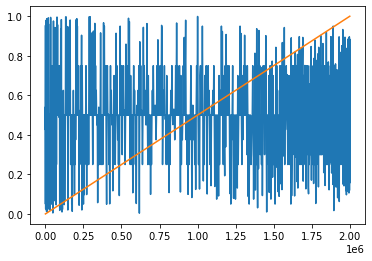

In [55]:
plt.plot(energies, mostProbablePositions)
plt.plot(energies, energies / 2e6)

In [56]:
regression = stats.linregress(mostProbablePositions, energies)

In [57]:
regression

LinregressResult(slope=-50782.31016782807, intercept=1025504.3057128468, rvalue=-0.01705501950301628, pvalue=0.5902860066580713, stderr=94286.49304420971, intercept_stderr=52032.14920288806)

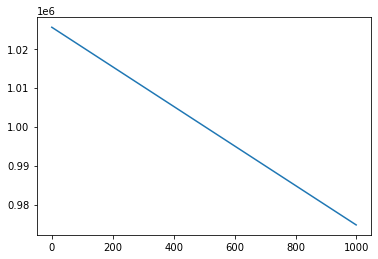

In [58]:
plt.plot(regression.slope * normalizedPositions + regression.intercept)

In [59]:
len(probabilityDistributions)

999

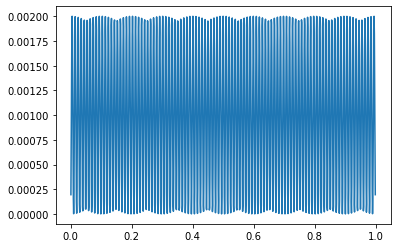

In [60]:
plt.plot(normalizedPositions[1:], probabilityDistributions[100])

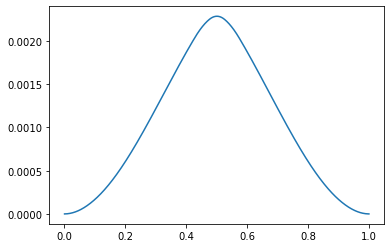

In [61]:
plt.plot(normalizedPositions[1:], probabilityDistributions[998])

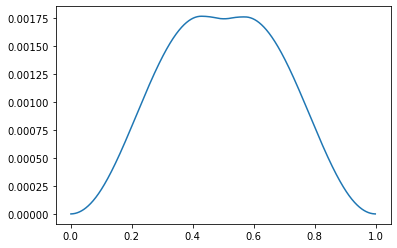

In [62]:
plt.plot(normalizedPositions[1:], probabilityDistributions[0])

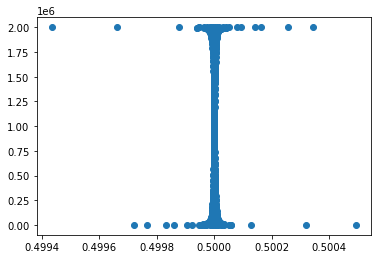

In [63]:
plt.scatter(expectationValues, energies)

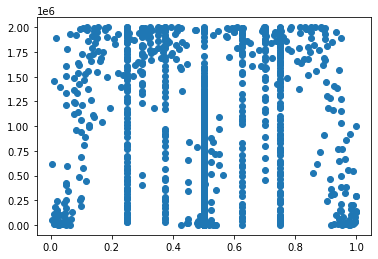

In [64]:
plt.scatter(mostProbablePositions, energies)